feature engineering to prepare training data for XGBoost and logistic regression.
1. Build a switcher where I can turn on and off each feature engineering step. In the notebook. should I still build the feature engineering steps on top of each other? i.e. ohe on imputed df.
2. Outliers: We don't want to remove it, leaving them untouched for XGBoost. However, logistic regression is more sensitive to outliers, so we need to handle it.
3. Missing values: XGBoost is good at dealing missing values. However, missing values are still imputed to prepare for other algorithm and compare model performance. 
4. Scaling: scale the data with robust scaler because there are significant outliers, still scaling is not very helpful for xgboost but we add it case we are trying other algorithms.
5. Mutual information evaluation after all the preprocessing to find significant input features. 
6. Build a base model evalution for the dataset, which is evaluated by recall@5% because it's highly imbalanced. 

# 1. Setup

In [1]:
print("Starting setups")
import sys
import os

Starting setups


In [2]:
dir_path = os.getcwd()
parent_dir = os.path.dirname(dir_path)
home_dir = os.path.dirname(parent_dir)
print("dir_path is", dir_path)
print("parent_dir is", parent_dir)
print("home_dir is", home_dir)

dir_path is /Users/zoe/Documents/Bank-account-fraud/code/feature_engineering
parent_dir is /Users/zoe/Documents/Bank-account-fraud/code
home_dir is /Users/zoe/Documents/Bank-account-fraud


In [3]:
import yaml
print(home_dir+'/params.yaml')
with open(home_dir+'/params.yaml', 'r') as file:
    params = yaml.safe_load(file)
params

/Users/zoe/Documents/Bank-account-fraud/params.yaml


{'data_location': '/data',
 'output_location': '/output',
 'code_location': '/code'}

In [4]:
data_folder = home_dir+params['data_location']
print('Data is stored at', data_folder)

Data is stored at /Users/zoe/Documents/Bank-account-fraud/data


In [5]:
with open(dir_path+"/feature_flag.yaml", "r") as file:
    config = yaml.safe_load(file)["feature_engineering"]

print(f"Current configuration for feature engineering is: {config}")

Current configuration for feature engineering is: {'impute': True, 'one_hot_encoding': True, 'smote': False, 'smote_oversample_ratio': 0.8, 'robust_scaler': True, 'binning': True, 'outlier_handling': False, 'mutual_information': True, 'chi2_test': True}


## 1.1 Import libraries and reading data

In [6]:
print("Importing packages and reading data...")

sys.path.append(os.path.abspath("feature_engineering"))
from preprocessing import *

import pandas as pd
pd.set_option('display.max_columns', 500)

import warnings as wr
wr.filterwarnings('ignore')

Importing packages and reading data...


In [7]:
sys.path

['/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/opt/homebrew/lib/python3.11/site-packages',
 '/Users/zoe/Documents/Bank-account-fraud/code/feature_engineering/feature_engineering']

In [8]:
df_base = pd.read_csv(f"{data_folder}/Base_backup.csv", header=0)
df = df_base.copy()

## 1.2 Drop features with no variance

In [9]:
constant_feature =[]
for x in df.columns:
    if df[x].nunique() == 1:
        constant_feature.append(x)
print("Dropping the constant features:", constant_feature)       
df = drop_columns(df, df[constant_feature])

Dropping the constant features: ['device_fraud_count']


### 1.3 Change the dataype of binary features into type boolean

In [10]:
print("Changing the dataype of binary features into type boolean")
binary_features = df.columns[df.nunique() == 2].tolist()

binary_features.remove('source')
# Convert these features"to boolean
df[binary_features] = df[binary_features].astype(bool)

# Verify changes
print(df[binary_features].dtypes)

Changing the dataype of binary features into type boolean
fraud_bool            bool
email_is_free         bool
phone_home_valid      bool
phone_mobile_valid    bool
has_other_cards       bool
foreign_request       bool
keep_alive_session    bool
dtype: object


# Binning and target encoding

In [11]:
# target encoding for housing_status instead of ohe
# use the proportion of the fraud cases of each category as the value 

df_encoded = df.copy()
df_encoded['housing_status_encoded'] = df_encoded['housing_status'].apply(lambda x: 'BA' if x == 'BA' else 'Other')

fraud_proportion = df_encoded[df_encoded['fraud_bool'] == 1]['housing_status_encoded'].value_counts() / df_encoded['housing_status_encoded'].value_counts()
fraud_proportion.sort_index()
print("variable housing_status - fraud_proportion by category \n", fraud_proportion)

df_encoded['housing_status_encoded'] = df_encoded['housing_status_encoded'].map(fraud_proportion)

df_encoded['housing_status_encoded']
df_encoded = df_encoded.drop(columns=['housing_status'])

variable housing_status - fraud_proportion by category 
 housing_status_encoded
BA       0.037466
Other    0.005627
Name: count, dtype: float64


0         0.005627
1         0.005627
2         0.005627
3         0.005627
4         0.005627
            ...   
999995    0.005627
999996    0.037466
999997    0.005627
999998    0.005627
999999    0.005627
Name: housing_status_encoded, Length: 1000000, dtype: float64

In [12]:
bins = {
    '10-50': range(10, 51), 
    '60-90': range(60, 91) 
}
df_encoded_binned = df_encoded.copy()
df_encoded_binned['customer_age_binned'] = df_encoded_binned['customer_age'].apply(
    lambda x: '10-50' if x in bins['10-50']
    else '60-90' if x in bins['60-90']
    else 'other'
)

fraud_proportion_age = df_encoded_binned[df_encoded_binned['fraud_bool'] == 1]['customer_age_binned'].value_counts() / df_encoded_binned['customer_age_binned'].value_counts()
fraud_proportion_age.sort_index()
print("variable housing_status - fraud_proportion by category \n", fraud_proportion_age)

df_encoded_binned['customer_age_encoded'] = df_encoded_binned['customer_age_binned'].map(fraud_proportion_age)
df_encoded_binned = df_encoded_binned.drop(columns=['customer_age_binned'])
df_encoded_binned['customer_age_encoded']

# X_train_binned['customer_age_binned_encoded'] = X_train_binned['customer_age_binned'].map(bin_to_fraud_proportion)

variable housing_status - fraud_proportion by category 
 customer_age_binned
10-50    0.009975
60-90    0.034693
Name: count, dtype: float64


0         0.009975
1         0.009975
2         0.009975
3         0.009975
4         0.009975
            ...   
999995    0.009975
999996    0.009975
999997    0.009975
999998    0.009975
999999    0.009975
Name: customer_age_encoded, Length: 1000000, dtype: float64

### potentially repeat the same for proposed_credit_limit, income, payment_type, employment_status

## 1.3 Train test split

In [13]:
df = df_encoded_binned.copy()

print("splitting train/test sets")
y = df['fraud_bool']
X = df.drop(columns=['fraud_bool'], axis = 1)

from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Training set (X_train) before feature engineering: {X_train.shape}")
print(f"Test set (X_test) before feature engineering: {X_test.shape}")
print(f"Training set (y_train) before feature engineering: {y_train.shape}")
print(f"Test set (y_test) before feature engineering: {y_test.shape}")

categorical_features, numerical_features = split_num_cat(df)
print('Categorical features before feature engineering:', categorical_features)
print('Numerical features before feature engineering:', numerical_features)

splitting train/test sets
Training set (X_train) before feature engineering: (800000, 32)
Test set (X_test) before feature engineering: (200000, 32)
Training set (y_train) before feature engineering: (800000,)
Test set (y_test) before feature engineering: (200000,)
Categorical features before feature engineering: ['income', 'customer_age', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'housing_status_encoded', 'customer_age_encoded']
Numerical features before feature engineering: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 's

## 2. Switcher

In [14]:
print("Start feature engineering steps...")

Start feature engineering steps...


In [15]:
if config["impute"]:
    print("Applying imputation for missing values...")
    X_train, X_test = impute_missing_values(X_train, X_test)
else:
    print("Not applying imputation.")

Applying imputation for missing values...
Features with missing values represented by -1:
['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
Train set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64

Test set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
Training set shape after imputation: (800000, 34)
Test set shape after imputation: (200000, 34)


Applying binning on bank_months_count...
the minimum value of bank_months_count is 0.0

 Bin Ranges:
Bin 1: [0.0, 1.0) -> Median: 0
Bin 2: [1.0, 5) -> Median: 2.5
Bin 3: [5, 9) -> Median: 6.5
Bin 4: [9, 13) -> Median: 10.5
Bin 5: [13, 17) -> Median: 14.5
Bin 6: [17, 21) -> Median: 18.5
Bin 7: [21, 25) -> Median: 22.5
Bin 8: [25, 29) -> Median: 26.5
Bin 9: [29, 33) -> Median: 30.5

 Bin medians and counts in training set:

bank_months_count_binned
0.0     202886
2.5     186125
6.5      37373
10.5     53539
14.5     51345
18.5     31604
22.5     30427
26.5    119801
30.5     86900
Name: count, dtype: int64


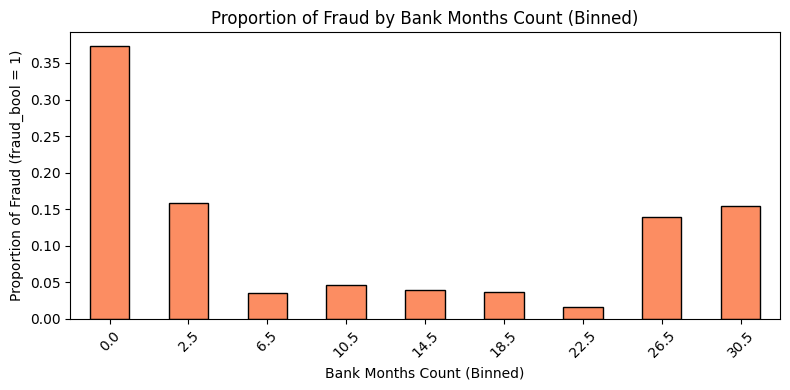

Final shape after binning - Train: (800000, 34), Test: (200000, 34)


In [16]:
if config["binning"]:
    print("Applying binning on bank_months_count...")
    X_train, X_test = bin_bank_months_count(X_train, X_test, y_train)
else:
    print("Not applying binning.")

In [17]:
cat_features, num_features = split_num_cat(X_train)
features_to_ohe = ['source', 'payment_type', 'employment_status', 
                   'device_os', 
                   'device_distinct_emails_8w',]
# for x in X_train[cat_features]: 
#     if X_train[x].nunique() < 9 and  X_train[x].nunique() > 2:
#         features_to_ohe.append(x)
features_to_ohe
        
if config["one_hot_encoding"]:
    print("Applying one-hot encoding...")
    X_train, X_test = one_hot_encode(X_train, X_test, features_to_ohe)
else:
    print("Not applying one hot encoder.")

Applying one-hot encoding...
Features to encode: ['source', 'payment_type', 'employment_status', 'housing_status', 'device_os', 'device_distinct_emails_8w', 'month']
One-hot encoded training shape: (800000, 64)
One-hot encoded test shape: (200000, 64)


In [18]:
if config["robust_scaler"]:
    print("Applying robust scaling...")
    X_train, X_test = robust_scaler(X_train, X_test)
else:
    print("Not applying scaler.")

Applying robust scaling...
Categorical features: ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'keep_alive_session', 'housing_status_encoded', 'customer_age_encoded', 'bank_months_count_was_missing', 'prev_address_months_count_was_missing', 'bank_months_count_binned', 'source_INTERNET', 'source_TELEAPP', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11', 'device_distinct_emails_8w_0.0', 'device_distinct_emails_8w_1.0', 'device_distinct

In [19]:
if config["outlier_handling"]:
    print("Removing outliers...")
    X_train, y_train = handle_outliers(X_train, y_train)
else:
    print("Not handling outliers")

Not handling outliers


In [20]:
if config["smote"]:
    print("Perfoming SMOTE to handle class imbalance")
    X_train, y_train = smote(X_train, y_train, over_ratio=config["smote_oversample_ratio"])
else:
    print("Not applying SMOTE")

Not applying SMOTE


## Feature selection

In [21]:
pd.set_option("display.max_rows", None)
print(X_train.nunique())

income                                          9
customer_age                                    9
email_is_free                                   2
phone_home_valid                                2
phone_mobile_valid                              2
has_other_cards                                 2
proposed_credit_limit                          12
foreign_request                                 2
keep_alive_session                              2
housing_status_encoded                          2
customer_age_encoded                            2
bank_months_count_was_missing                   2
prev_address_months_count_was_missing           2
bank_months_count_binned                        9
source_INTERNET                                 2
source_TELEAPP                                  2
payment_type_AA                                 2
payment_type_AB                                 2
payment_type_AC                                 2
payment_type_AD                                 2


In [34]:
categorical_var, numerical_var = split_num_cat(X_train)
len(categorical_var)

50

Calculating mutual information scores based on the final training set
Mutual Information Scores:
housing_status_BA                          0.005328
scaled_credit_risk_score                   0.004526
housing_status_encoded                     0.003831
device_os_windows                          0.003600
scaled_date_of_birth_distinct_emails_4w    0.003507
proposed_credit_limit                      0.002637
customer_age_encoded                       0.002129
prev_address_months_count_was_missing      0.001969
email_is_free                              0.001859
keep_alive_session                         0.001695
device_distinct_emails_8w_1.0              0.001631
income                                     0.001556
customer_age                               0.001516
device_os_other                            0.001328
employment_status_CG                       0.001188
device_os_linux                            0.001138
housing_status_BC                          0.001107
scaled_name_email_s

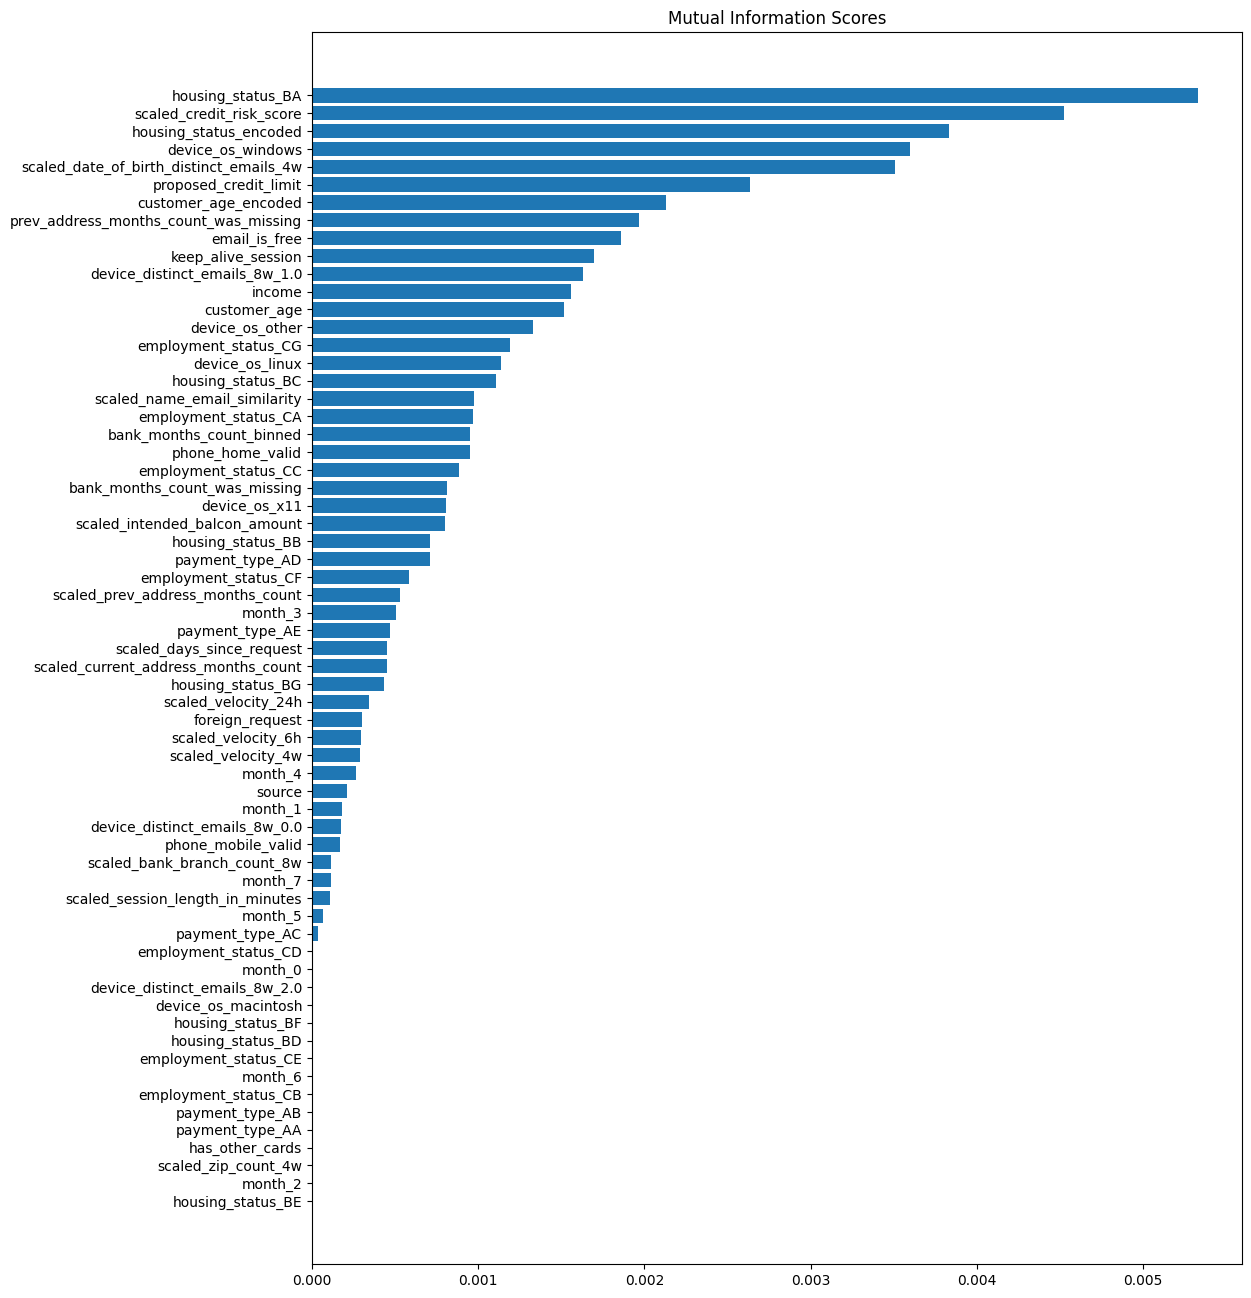

Calculating chi2 based on the final training set


ValueError: could not convert string to float: 'INTERNET'

In [36]:
if config["mutual_information"]:
    print("Calculating mutual information scores based on the final training set")
    mi_scores = mutual_information(X_train, y_train)
else:
    print("Not calculating mutual information")

Calculating chi2 based on the final training set
Chi-Square Test Results:
                                  feature    chi2_score        p_value
1                            customer_age  1.386932e+04   0.000000e+00
28                      housing_status_BA  8.739463e+03   0.000000e+00
42          device_distinct_emails_8w_2.0  1.643693e+03   0.000000e+00
6                   proposed_credit_limit  1.770965e+06   0.000000e+00
38                      device_os_windows  3.714831e+03   0.000000e+00
8                      keep_alive_session  8.735908e+02  5.407087e-192
35                        device_os_linux  8.608609e+02  3.165200e-189
5                         has_other_cards  7.581747e+02  6.697868e-167
37                        device_os_other  7.212952e+02  6.998634e-159
32                      housing_status_BE  7.182984e+02  3.138047e-158
30                      housing_status_BC  6.564961e+02  8.636515e-145
16                        payment_type_AA  6.540571e+02  2.929354e-144
23 

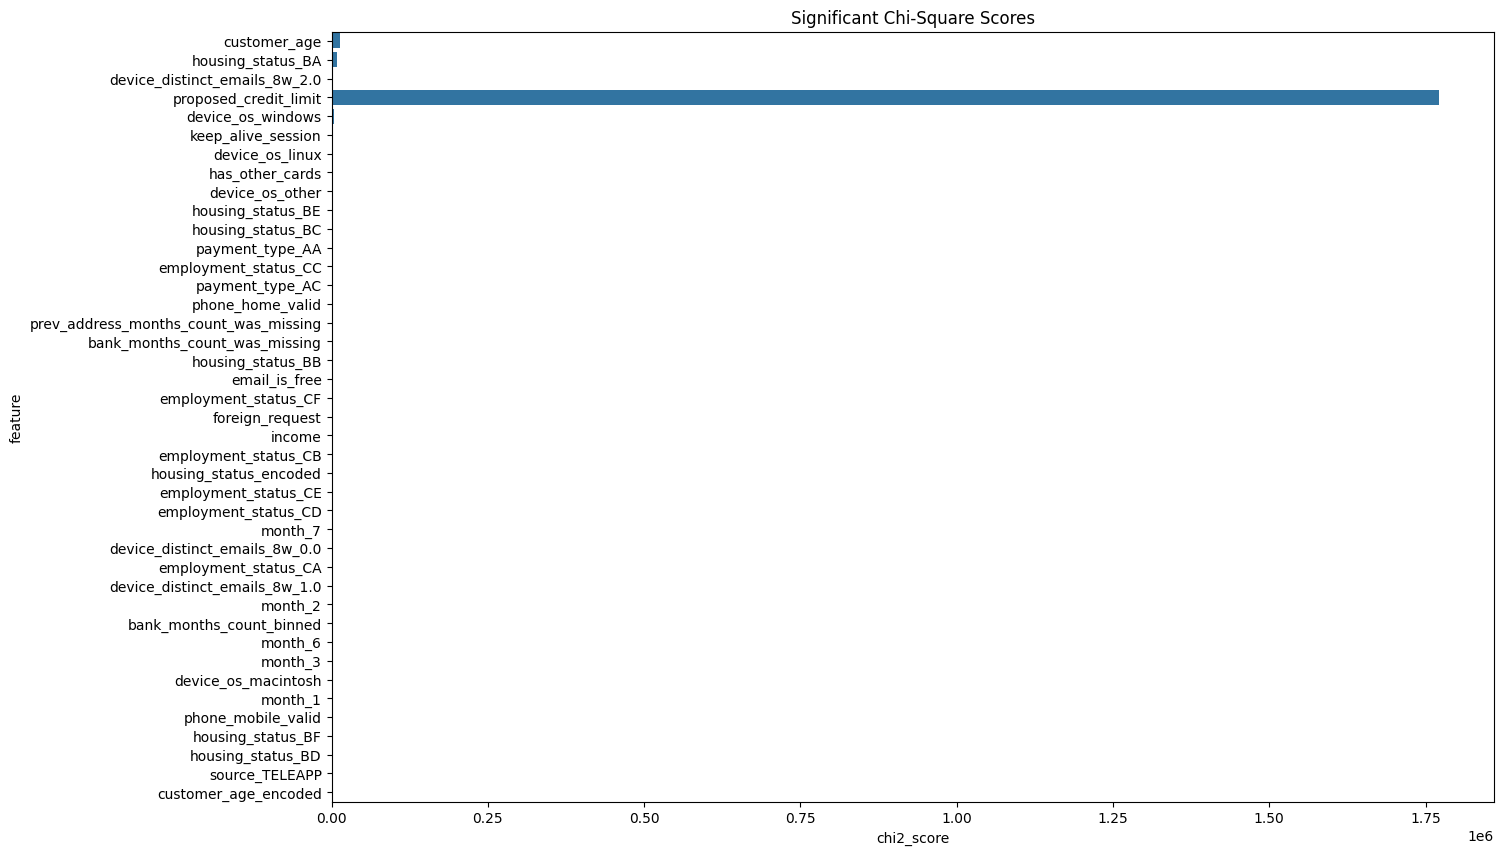

In [22]:
 if config["chi2_test"]:
    print("Calculating chi2 based on the final training set")
    chi2_results = chi2_test(X_train, y_train)
else:
    print("Not calculating chi2")

# Save the final output 

In [ ]:
# print("Exporting final dataset...")
# export_final_df(X_train, y_train, X_test, y_test, data_folder, 
#                 "no_smote_x_train.csv", "no_smote_y_train.csv", 
#                 "no_smote_x_test.csv", "no_smote_y_test.csv")

In [23]:
print("Exporting final dataset...")
export_final_df(X_train, y_train, X_test, y_test, data_folder, 
                "target_encoded_x_train.csv", "target_encoded_y_train.csv", 
                "target_encoded_x_test.csv", "target_encoded_y_test.csv")

Exporting final dataset...
Final X_train shape (800000, 64)
Final y_train shape (800000,)
Final X_test shape (200000, 64)
Final y_test shape (200000,)
Feature engineering is done. Exporting the final training and test data to: /Users/zoe/Documents/Bank-account-fraud/data
target_encoded_x_train.csvis exported to /Users/zoe/Documents/Bank-account-fraud/data
target_encoded_x_test.csvis exported to /Users/zoe/Documents/Bank-account-fraud/data
target_encoded_y_train.csvis exported to /Users/zoe/Documents/Bank-account-fraud/data
target_encoded_y_test.csvis exported to /Users/zoe/Documents/Bank-account-fraud/data
Data successfully exported into CSV!
